# Calculating coordination numbers

In this example, we will read in a configuration from an MD simulation and then calculate the coordination number distribution. 

<div class="admonition note" name="html-admonition" style="background: #d1c4e9; padding: 10px">
<p class="title"><b>Methods</b></p>
For a detailed description of methods see [Methods section](method)
</div>

In [1]:
from pyscal3 import System 
import numpy as np
import matplotlib.pyplot as plt

### Read in a file

Lets create a bcc structure

In [2]:
sys = System.create.lattice.bcc(lattice_constant= 4.00, repetitions=[6,6,6])

The above function creates an bcc crystal of 6x6x6 unit cells with a lattice constant of 4.00 along with a simulation box that encloses the particles.

### Calculating neighbors

We start by calculating the neighbors of each atom in the system. There are two (main) ways to do this, using a ``cutoff`` method and using a ``voronoi`` polyhedra method. We will try with both of them. First we try with cutoff system - which has three sub options. We will check each of them in detail.

#### Cutoff method

Cutoff method takes cutoff distance value and finds all atoms within the cutoff distance of the host atom.

In [4]:
sys.find.neighbors(method='cutoff', cutoff=4.1)

let us try accessing the coordination number of an atom

In [5]:
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]

In [6]:
coordination[0]

14

As we would expect for a bcc type lattice, we see that the atom has 14 neighbors (8 in the first shell and 6 in the second). Lets try a more interesting example by reading in a bcc system with thermal vibrations. Thermal vibrations lead to distortion in atomic positions, and hence there will be a distribution of coordination numbers.

In [8]:
sys = System('conf.dump')
sys.find.neighbors(method='cutoff', cutoff=3.6)

/home/menon/miniconda3/envs/pyscal-test/lib/python3.10/site-packages/pyscal3/atoms.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dict.__setitem__(self, key, np.array(val))


We can loop over all atoms and create a histogram of the results 

In [9]:
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]

Now lets plot and see the results

Text(0.5, 1.0, 'Cutoff method')

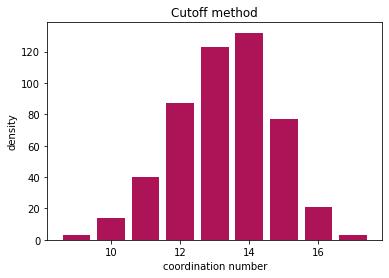

In [11]:
nos, counts = np.unique(coordination, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Cutoff method")

### Adaptive cutoff methods

``pyscal`` also has adaptive cutoff methods implemented. These methods remove the restriction on having the same cutoff. A distinct cutoff is selected for each atom during runtime. ``pyscal`` uses two distinct algorithms to do this - ``sann`` and ``adaptive``. Please check the [documentation](https://pyscal.readthedocs.io/en/latest/nearestneighbormethods.html) for a explanation of these algorithms.  For the purpose of this example, we will use the `adaptive` algorithm.

``adaptive algorithm``

In [12]:
sys.find.neighbors(method='cutoff', cutoff='adaptive', padding=1.5)
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]

Now lets plot

Text(0.5, 1.0, 'Cutoff adaptive method')

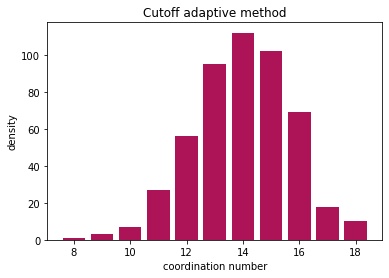

In [13]:
nos, counts = np.unique(coordination, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Cutoff adaptive method")

The adaptive method also gives similar results!

### Voronoi method

Voronoi method calculates the voronoi polyhedra of all atoms. Any atom that shares a voronoi face area with the host atom are considered neighbors. Voronoi polyhedra is calculated using the [Voro++](http://math.lbl.gov/voro++/) code. However, you dont need to install this specifically as it is linked to pyscal.

In [14]:
sys.find.neighbors(method='voronoi')

Once again, let us get all atoms and find their coordination

In [15]:
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]

And visualise the results

Text(0.5, 1.0, 'Voronoi method')

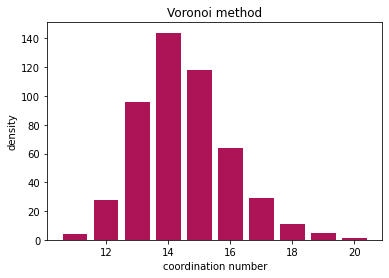

In [16]:
nos, counts = np.unique(coordination, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Voronoi method")

### Finally..

All methods find the coordination number, and the results are comparable. Cutoff method is very sensitive to the choice of cutoff radius, but voronoi method can slightly overestimate the neighbors due to thermal vibrations. 

<div class="admonition note" name="html-admonition" style="background: #d1c4e9; padding: 10px">
<p class="title"><b>About small simulation boxes</b></p>
pyscal repeats the simulation box to create ghost atoms if the input cell is too small. This means that when the neighbors of an atom are extracted, some indices might be repeated.
</div>

<hr width="100%" size="10" color="#9575cd" noshade>

(method)=
## Methods

pyscal3 includes different methods to explore the local environment of a particle that rely on the calculation of nearest neighbors. Various approaches to compute the neighbors of particles are discussed here.

### Fixed cutoff method

The most common method to calculate the nearest neighbors of an atom is using a cutoff radius. Commonly, a cutoff is selected as the first minimum of the radial distribution functions. Once a cutoff is selected, the neighbors of an atom are those that fall within this selected radius. The following code snippet will use the cutoff method to calculate neighbors. In this example, `conf.dump` is assumed to
be the input configuration of the system. A cutoff radius of 3 is assumed for calculation of neighbors.

``` python
from pyscal3 import System
sys = pc.System()
sys.read.file('conf.dump')
sys.find.neighbors(method='cutoff', cutoff=3)
```

## Adaptive cutoff methods

A fixed cutoff radius can introduce limitations to explore the local environment of the particle in some cases:

-   At finite temperatures, when thermal fluctuations take place, the selection of a fixed cutoff may result in an inaccurate description of the local environment.
-   If there is more than one structure present in the system, for example, bcc and fcc, the selection of cutoff such that it includes the first shell of both structures can be difficult.

In order to achieve a more accurate description of the local environment, various adaptive approaches have been proposed. Two of the methods implemented in the module are discussed below.

### Solid angle based nearest neighbor algorithm (SANN)

SANN algorithm [1] determines the cutoff radius by counting the solid angles around an atom and equating it to $4\pi$. The algorithm solves the following equation iteratively.

$$
R_i^{(m)} = \frac{\sum_{j=1}^m r_{i,j}}{m-2} < r_{i, m+1}
$$

where $i$ is the host atom, $j$ are its neighbors with $r_{ij}$ is the distance between atoms $i$ and $j$. $R_i$ is the cutoff radius for each particle $i$ which is found by increasing the neighbor of neighbors $m$ iteratively. For a description of the algorithm and more details, please check the reference [1]. SANN algorithm can be used to find the neighbors by,

``` python
from pyscal3 import System
sys = pc.System()
sys.read.file('conf.dump')
sys.find.neighbors(method='cutoff', cutoff='sann')
```

Since SANN algorithm involves sorting, a sufficiently large cutoff is used in the beginning to reduce the number entries to be sorted. This parameter is calculated by,

$$
r_{initial} = \mathrm{threshold} \times \bigg(\frac{\mathrm{Simulation~box~volume}}{\mathrm{Number~of~particles}}\bigg)^{\frac{1}{3}}
$$

a tunable `threshold` parameter can be set through function arguments.

### Adaptive cutoff method

An adaptive cutoff specific for each atom can also be found using an algorithm similar to adaptive common neighbor analysis [2]. This adaptive cutoff is calculated by first making a list of all neighbor
distances for each atom similar to SANN method. Once this list is available, then the cutoff is calculated from,

$$
r_{cut}(i) = \mathrm{padding}\times \bigg(\frac{1}{\mathrm{nlimit}} \sum_{j=1}^{\mathrm{nlimit}} r_{ij} \bigg)
$$

This method can be chosen by,

``` python
from pyscal3 import System
sys = pc.System()
sys.read.file('conf.dump')
sys.find.neighbors(method='cutoff', cutoff='adaptive')
```

The `padding` and `nlimit` parameters in the above equation can be tuned using the respective keywords.

Either of the adaptive method can be used to find neighbors, which can then be used to calculate Steinhardt\'s parameters or their averaged version.

### Voronoi tessellation

[Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram) provides a completely parameter free geometric approach for calculation of neighbors. [Voro++](http://math.lbl.gov/voro++/) code is used for Voronoi tessellation. Neighbors can be calculated using this method by,

``` python
from pyscal3 import System
sys = pc.System()
sys.read.file('conf.dump')
sys.find.neighbors(method='voronoi')
```

Finding neighbors using Voronoi tessellation also calculates a weight for each neighbor. The weight of a neighbor $j$ towards a host atom $i$ is given by,

$$
W_{ij} = \frac{A_{ij}}{\sum_{j=1}^N A_{ij}}
$$

where $A_{ij}$ is the area of Voronoi facet between atom $i$ and $j$, $N$ are all the neighbors identified through Voronoi tessellation. This weight can be used later for calculation of weighted Steinhardt's
parameters. Optionally, it is possible to choose the exponent for this weight. Option `voroexp` is used to set this option. For example if `voroexp=2`, the weight would be calculated as,

$$
W_{ij} = \frac{A_{ij}^2}{\sum_{j=1}^N A_{ij}^2}
$$

### References

1. van Meel, J. A., Filion, L., Valeriani, C. & Frenkel, D. A parameter-free, solid-angle based, nearest- neighbor algorithm. J Chem Phys 234107, (2012).
2. Stukowski, A. Structure identification methods for atomistic simulations of crystalline materials. Modelling and Simulation in Materials Science and Engineering 20, (2012).